In [1]:
import itertools
import torch
import torch.nn as nn
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import uniform
from scipy.stats import randint

from skorch import NeuralNetBinaryClassifier

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

dtype = torch.float
device = torch.device("cpu")

## Defining resources
We define some relevant functions and costant variables to use in this notebook.

In [2]:
#define a function that split target column from dataset.
def split_train_test(df_monk_train, df_monk_test):
    target_train = df_monk_train[['class']]
    df_monk_train.drop(labels='class', axis=1, inplace=True)
    target_test = df_monk_test[['class']]
    df_monk_test.drop(labels='class', axis=1, inplace=True)
    X_train = df_monk_train.values #returns a ndarray
    y_train = target_train.values.ravel() #flattens the array into a 1-dimensional array
    X_test = df_monk_test.values
    y_test = target_test.values.ravel()

    return X_train, y_train, X_test, y_test

In [3]:
#define mee loss function 
def mee(true_target, predicted_target):  # assuming target is 2-dim matrix with x and y as columns
    l = true_target.shape[0]
    res = 0

    for p in range(l):  # for p-th pattern in l (number of samples)
        x_diff = np.square(true_target[p, 0] - predicted_target[p, 0])  # difference between the x value of the true and predicted target
        y_diff = np.square(
            true_target[p, 1] - predicted_target[p, 1])  # difference between the y values of true and predicted target
        sum_term = x_diff + y_diff
        res = res + np.sqrt(sum_term)
    res = res / l

    return res

In [4]:
#define a neural network
class BinaryClassification(nn.Module):
    def __init__(self, n_input = 6, hidden_units = 100):
        super(BinaryClassification, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(n_input, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, 1)
        )
        
    def forward(self, inputs, **kwargs):
        x = self.layers(inputs)

        return x

In [5]:
def plot_learning_curves(train_scores, test_scores, epochs, y_label):
    plt.figure(figsize=(10,8))
    plt.plot(range(0,epochs), train_scores, label = "Training error", linestyle='dashed')
    plt.plot(range(0,epochs), test_scores, label = "Test error")
    plt.legend(fontsize=15)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel(y_label, fontsize=20) 
    plt.xlabel('Epoch', fontsize=20);

## Loading MONK-1 dataset
Now we load the first MONK dataset.

In [6]:
#read train dataset
df_monk1_train = pd.read_csv('./data/MONK/monks-1.train', sep=" ", skipinitialspace=True, names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk1_train.drop(labels='id', axis=1, inplace=True)

#read test dataset
df_monk1_test = pd.read_csv('./data/MONK/monks-1.test', sep=" ", skipinitialspace=True,  names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk1_test.drop(labels='id', axis=1, inplace=True)

In [7]:
df_monk1_test #first column is the target (can be either 0 or 1)

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,1,1
1,1,1,1,1,1,1,2
2,1,1,1,1,1,2,1
3,1,1,1,1,1,2,2
4,1,1,1,1,1,3,1
...,...,...,...,...,...,...,...
427,1,3,3,2,3,2,2
428,1,3,3,2,3,3,1
429,1,3,3,2,3,3,2
430,1,3,3,2,3,4,1


In [8]:
df_monk1_train

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,3,1
1,1,1,1,1,1,3,2
2,1,1,1,1,3,2,1
3,1,1,1,1,3,3,2
4,1,1,1,2,1,2,1
...,...,...,...,...,...,...,...
119,1,3,3,2,1,4,2
120,1,3,3,2,3,1,2
121,1,3,3,2,3,2,2
122,1,3,3,2,3,3,2


<AxesSubplot:ylabel='class'>

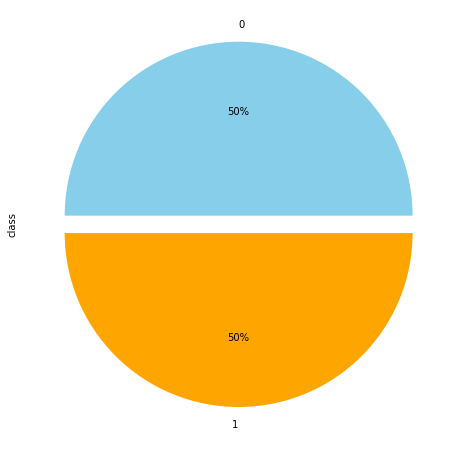

In [9]:
#plot class distribution in train data
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

df_monk1_train['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'], explode=(0.05, 0.05))

<AxesSubplot:ylabel='class'>

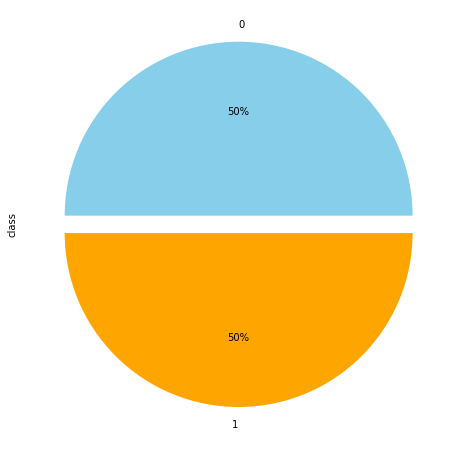

In [10]:
#plot class distribution in test data
df_monk1_test['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'], explode=(0.05, 0.05))

In [11]:
X_train_M1, y_train_M1, X_test_M1, y_test_M1 = split_train_test(df_monk1_train, df_monk1_test)

### Using skorch and sklearn
In this part, use skorch and sklearn to define a good model with MONKs

In [12]:
#trains the model with one iteration (epoch) and computes in output a list of train and test scores using MEE
def fit_and_score_monk(epochs, eval_model, X_train, y_train, X_test, y_test):
    train_scores = []
    test_scores = []
    train_loss = []
    test_loss = []
    train_loss_mse = []
    test_loss_mse = []

    for i in range(epochs):
        eval_model = eval_model.partial_fit(X_train,y_train, classes = np.unique(y_train))
        y_train_predicted = eval_model.predict(X_train)
        y_test_predicted = eval_model.predict(X_test)
        #results on train set
        train_loss.append(log_loss(y_train, y_train_predicted))
        train_loss_mse.append(mean_squared_error(y_train, y_train_predicted))
        train_scores.append(accuracy_score(y_train, y_train_predicted))
        #result on test set
        test_loss.append(log_loss(y_test, y_test_predicted))
        test_loss_mse.append(mean_squared_error(y_test, y_test_predicted))
        test_scores.append(accuracy_score(y_test, y_test_predicted))
    return train_scores, test_scores, train_loss, test_loss, train_loss_mse, test_loss_mse

### One hot encoding in MONK-1
In the MONK dataset we have the categories encoded using label encoding (e.g. 0,1,2,..), we need to use one hot encoding in order to have better results (e.g. 001, 010, ..). 

In [13]:
enc_train = OneHotEncoder()
enc_train.fit(X_train_M1)
X_train_M1 = enc_train.transform(X_train_M1).toarray()
print(X_train_M1.shape)

enc_test = OneHotEncoder()
enc_test.fit(X_test_M1)
X_test_M1 = enc_test.transform(X_test_M1).toarray()
print(X_test_M1.shape)

(124, 17)
(432, 17)


In [14]:
#cast train set and test set to Float
X_trainFit_enc = X_train_M1.astype(np.single)
y_trainFit_enc = y_train_M1.astype(np.single)

X_testFit_enc = X_test_M1.astype(np.single)
y_testFit_enc = y_test_M1.astype(np.single)

In [15]:
%%time

net_enc = NeuralNetBinaryClassifier(
    BinaryClassification,
    module__n_input=X_trainFit_enc.shape[1],
    module__hidden_units=4,
    max_epochs=1,
    batch_size=4,
    lr = 0.057,
    optimizer=torch.optim.SGD,
    #optimizer__weight_decay=0.001,
    #optimizer__momentum=0.85,
    #optimizer__nesterov=True,
    # Shuffle training data on each epoch
    #iterator_train__shuffle=True,
    train_split=None
)

train_scores_M1, test_scores_M1, train_loss_M1, test_loss_M1, train_loss_M1_mse, test_loss_M1_mse = fit_and_score_monk(150, net_enc, X_trainFit_enc, y_trainFit_enc, X_testFit_enc, y_testFit_enc)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.6987  0.0951
      2        0.6883  0.0895
      3        0.6760  0.1240
      4        0.6591  0.1185
      5        0.6368  0.0990
      6        0.6066  0.0896
      7        0.5749  0.0965
      8        0.5429  0.1048
      9        0.5133  0.1000


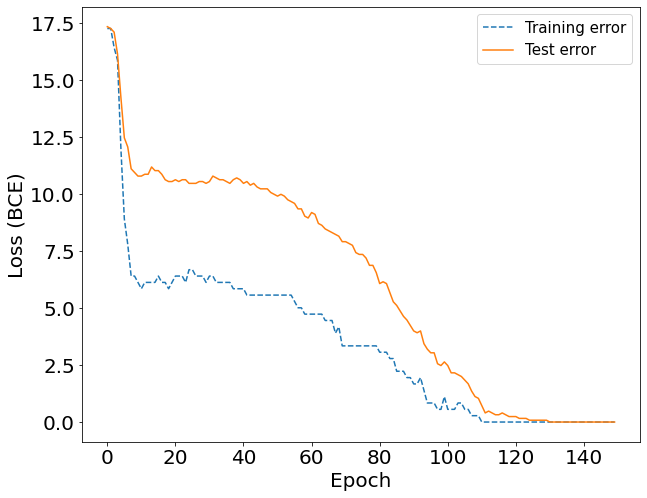

In [16]:
plot_learning_curves(train_loss_M1, test_loss_M1, 150, 'Loss (BCE)')

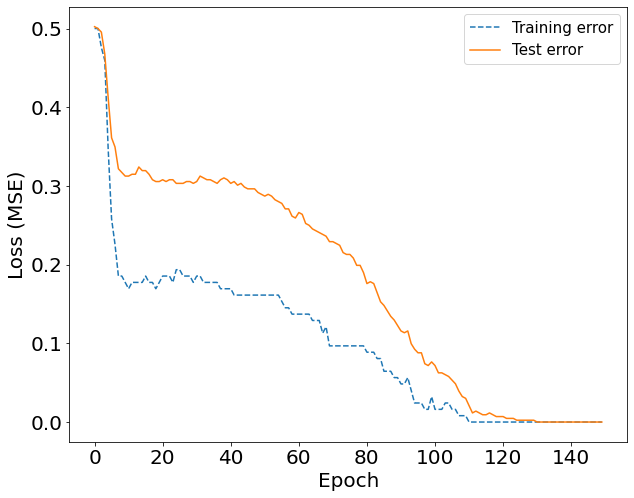

In [17]:
plot_learning_curves(train_loss_M1_mse, test_loss_M1_mse, 150, 'Loss (MSE)')

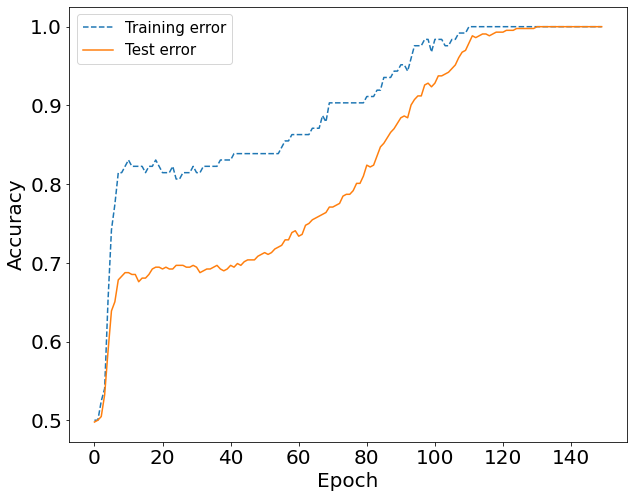

In [18]:
plot_learning_curves(train_scores_M1, test_scores_M1, 150, 'Accuracy')

In [21]:
y_predicted_train_M1 = net_enc.predict(X_trainFit_enc)
y_predicted_test_M1 = net_enc.predict(X_testFit_enc)
print(f"Accuracy on MONK1: {net_enc.score(X_testFit_enc, y_testFit_enc)}")
print(f"MEE on MONK1: {(np.linalg.norm(y_predicted_test_M1-y_testFit_enc))}") # MEE distance (a.k.a. norm 2)
print(f"MSE on MONK1 (TRAIN): {(mean_squared_error(y_trainFit_enc, y_predicted_train_M1))}")
print(f"MSE on MONK1 (TEST): {(mean_squared_error(y_testFit_enc, y_predicted_test_M1))}")

Accuracy on MONK1: 1.0
MEE on MONK1: 0.0
MSE on MONK1 (TRAIN): 0.0
MSE on MONK1 (TEST): 0.0


In [23]:
#control the accuracy between true and predict values on test data
print(classification_report(y_testFit_enc, y_predicted_test_M1))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       216
         1.0       1.00      1.00      1.00       216

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432



### Loading MONK-2 dataset

In [24]:
df_monk2_train = pd.read_csv('./data/MONK/monks-2.train', sep=" ", skipinitialspace=True, names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk2_train.drop(labels='id', axis=1, inplace=True)

df_monk2_test = pd.read_csv('./data/MONK/monks-2.test', sep=" ", skipinitialspace=True,  names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk2_test.drop(labels='id', axis=1, inplace=True)

In [25]:
df_monk2_test.head() #first column is the target (can be either 0 or 1)

,class,a1,a2,a3,a4,a5,a6
0,0,1,1,1,1,1,1
1,0,1,1,1,1,1,2
2,0,1,1,1,1,2,1
3,0,1,1,1,1,2,2
4,0,1,1,1,1,3,1


In [26]:
df_monk2_train

,class,a1,a2,a3,a4,a5,a6
0,0,1,1,1,1,2,2
1,0,1,1,1,1,4,1
2,0,1,1,1,2,1,1
3,0,1,1,1,2,1,2
4,0,1,1,1,2,2,1
...,...,...,...,...,...,...,...
164,0,3,3,2,2,3,1
165,0,3,3,2,2,3,2
166,1,3,3,2,3,1,1
167,0,3,3,2,3,2,1


<AxesSubplot:ylabel='class'>

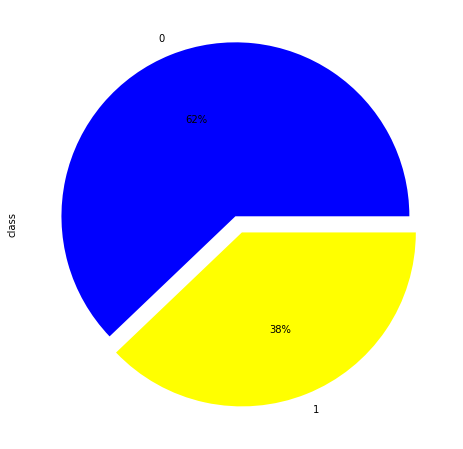

In [27]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

df_monk2_train['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['blue', 'yellow'], explode=(0.05, 0.05))

<AxesSubplot:ylabel='class'>

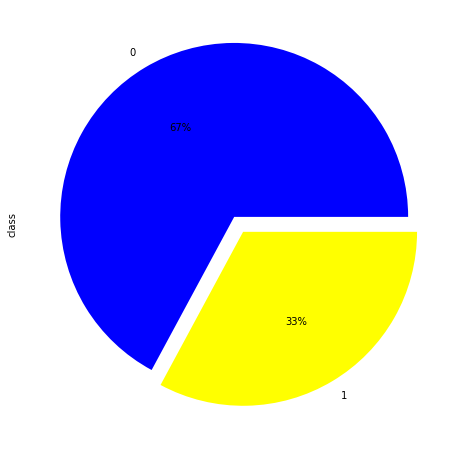

In [28]:
df_monk2_test['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['blue', 'yellow'], explode=(0.05, 0.05))

In [29]:
X_train_M2, y_train_M2, X_test_M2, y_test_M2 = split_train_test(df_monk2_train, df_monk2_test)

In [30]:
enc_train = OneHotEncoder()
enc_train.fit(X_train_M2)
X_train_M2 = enc_train.transform(X_train_M2).toarray()
print(X_train_M2.shape)

enc_test = OneHotEncoder()
enc_test.fit(X_test_M2)
X_test_M2 = enc_test.transform(X_test_M2).toarray()
print(X_test_M2.shape)


(169, 17)
(432, 17)


In [31]:
#cast train set and test set to Float
X_trainFit2 = X_train_M2.astype(np.single)
y_trainFit2 = y_train_M2.astype(np.single)

X_testFit2 = X_test_M2.astype(np.single)
y_testFit2 = y_test_M2.astype(np.single)

In [33]:
%%time #Wall time: 5.98 s

net_enc2 = NeuralNetBinaryClassifier(
    BinaryClassification,
    module__n_input=X_trainFit2.shape[1],
    module__hidden_units=4,
    max_epochs=1,
    batch_size = 8,
    lr = 0.1,
    optimizer=torch.optim.SGD,
    #optimizer__weight_decay=0.001,
    #optimizer__momentum=0.95,
    # Shuffle training data on each epoch
    #iterator_train__shuffle=True,
    train_split=None
)

train_scores_M2, test_scores_M2, train_loss_M2, test_loss_M2, train_loss_M2_mse, test_loss_M2_mse = fit_and_score_monk(100, net_enc2, X_trainFit2, y_trainFit2, X_testFit2, y_testFit2)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.6741  0.1005
      2        0.6648  0.1042
      3        0.6621  0.1009
      4        0.6600  0.0964
      5        0.6580  0.0265
      6        0.6561  0.0802
      7        0.6540  0.1036
      8        0.6520  0.1071
      9        0.6502  0.0230
     10        0.6480  0.0927
     11        0.6462  0.0966
     12        0.6442  0.1727
     13        0.6423  0.1125
     14        0.6391  0.1672
     15        0.6375  0.0950
     16        0.6346  0.0881
     17        0.6319  0.0979
     18        0.6265  0.0203
     19        0.6204  0.0885
     20        0.6127  0.1171
     21        0.6050  0.0996
     22        0.5976  0.0885
     23        0.5851  0.0361
     24        0.5670  0.1228
     25        0.5485  0.1033
     26        0.5297  0.0903
     27        0.5107  0.0996
     28        0.4897  0.0833
     29        0.4694  0.0745
     30        0.4495  0.0871
     31        0.4283  0.0231
     32   

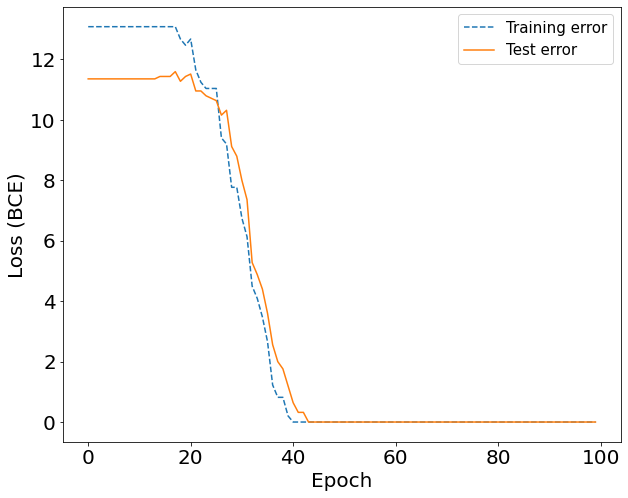

In [34]:
plot_learning_curves(train_loss_M2, test_loss_M2, 100, 'Loss (BCE)')

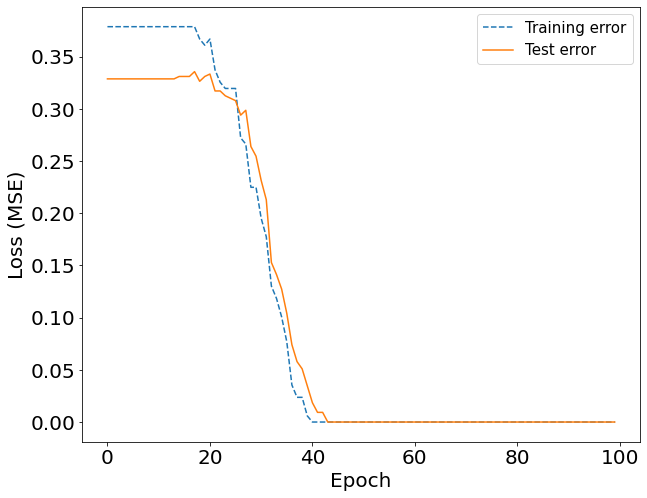

In [35]:
plot_learning_curves(train_loss_M2_mse, test_loss_M2_mse, 100, 'Loss (MSE)')

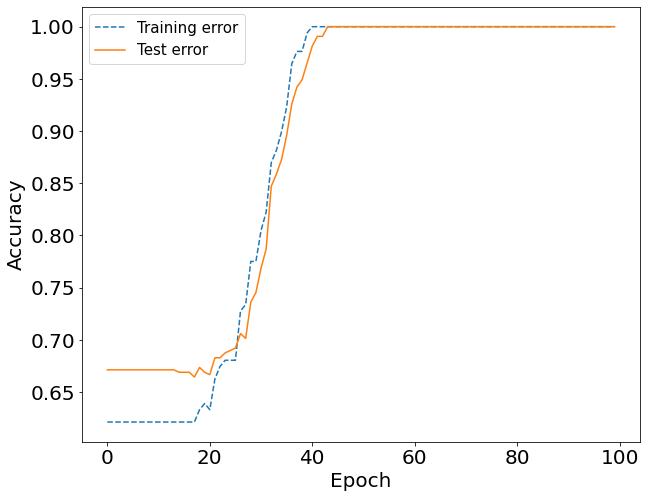

In [36]:
plot_learning_curves(train_scores_M2, test_scores_M2, 100, 'Accuracy')

In [37]:
y_predicted_train_M2 = net_enc2.predict(X_trainFit2)
y_predicted_test_M2 = net_enc2.predict(X_testFit2)
print(f"Accuracy on MONK2: {net_enc2.score(X_testFit2, y_testFit2)}")
print(f"MEE on MONK2: {(np.linalg.norm(y_predicted_test_M2-y_testFit2))}") # MEE distance (a.k.a. norm 2)
print(f"MSE on MONK2 (TRAIN): {(mean_squared_error(y_trainFit2, y_predicted_train_M2))}")
print(f"MSE on MONK2 (TEST): {(mean_squared_error(y_testFit2, y_predicted_test_M2))}")

Accuracy on MONK2: 1.0
MEE on MONK2: 0.0
MSE on MONK2 (TRAIN): 0.0
MSE on MONK2 (TEST): 0.0


In [38]:
#control the accuracy between true and predict values on test data
print(classification_report(y_testFit2, y_predicted_test_M2))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       290
         1.0       1.00      1.00      1.00       142

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432



## Loading MONK-3 dataset

In [39]:
#read train dataset
df_monk3_train = pd.read_csv('./data/MONK/monks-3.train', sep=" ", skipinitialspace=True, names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk3_train.drop(labels='id', axis=1, inplace=True)

#read test dataset
df_monk3_test = pd.read_csv('./data/MONK/monks-3.test', sep=" ", skipinitialspace=True,  names=['class','a1','a2','a3','a4','a5','a6','id'])
df_monk3_test.drop(labels='id', axis=1, inplace=True)

In [40]:
df_monk3_train.head()

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,1,2
1,1,1,1,1,1,2,1
2,1,1,1,1,1,2,2
3,0,1,1,1,1,3,1
4,0,1,1,1,1,4,1


In [41]:
df_monk3_test.head()

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,1,1
1,1,1,1,1,1,1,2
2,1,1,1,1,1,2,1
3,1,1,1,1,1,2,2
4,1,1,1,1,1,3,1


<AxesSubplot:ylabel='class'>

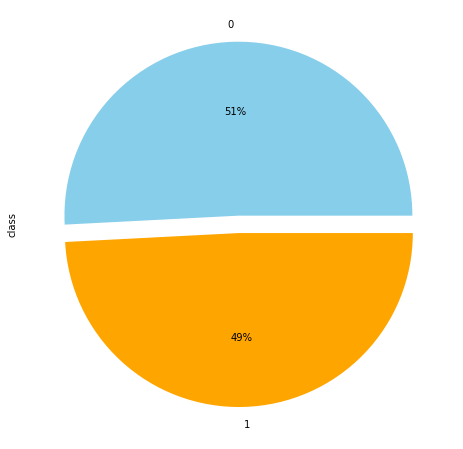

In [42]:
#plot class distribution in train data
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

df_monk3_train['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'], explode=(0.05, 0.05))

<AxesSubplot:ylabel='class'>

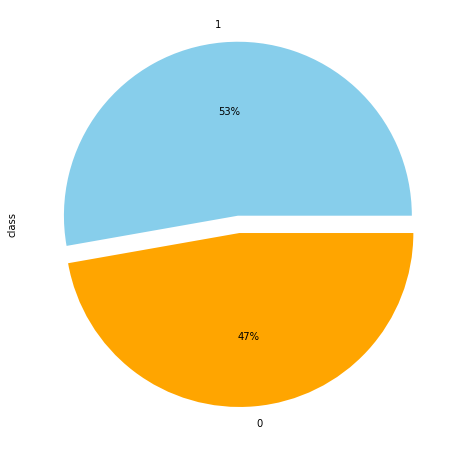

In [43]:
#plot class distribution in test data
df_monk3_test['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'], explode=(0.05, 0.05))

In [44]:
X_train_M3, y_train_M3, X_test_M3, y_test_M3 = split_train_test(df_monk3_train, df_monk3_test)

In [45]:
enc_train = OneHotEncoder()
enc_train.fit(X_train_M3)
X_train_M3 = enc_train.transform(X_train_M3).toarray()
print(X_train_M3.shape)

enc_test = OneHotEncoder()
enc_test.fit(X_test_M3)
X_test_M3 = enc_test.transform(X_test_M3).toarray()
print(X_test_M3.shape)

(122, 17)
(432, 17)


In [46]:
#cast train set and test set to Float
X_trainFit3 = X_train_M3.astype(np.single)
y_trainFit3 = y_train_M3.astype(np.single)

X_testFit3 = X_test_M3.astype(np.single)
y_testFit3 = y_test_M3.astype(np.single)

In [51]:
%%time 

net_enc3_noreg = NeuralNetBinaryClassifier(
    BinaryClassification,
    module__n_input=X_trainFit3.shape[1],
    module__hidden_units=4,
    max_epochs=1,
    batch_size = 8,
    lr = 0.008,
    optimizer=torch.optim.SGD,
    #optimizer__weight_decay=0.0001,
    #optimizer__momentum=0.95,
    #optimizer__nesterov=True,
    # Shuffle training data on each epoch
    #iterator_train__shuffle=True,
    train_split=None
)

train_scores_M3_noreg, test_scores_M3_noreg, train_loss_M3_noreg, test_loss_M3_noreg, train_loss_M3_mse_noreg, test_loss_M3_mse_noreg = fit_and_score_monk(300, net_enc3_noreg, X_trainFit3, y_trainFit3, X_testFit3, y_testFit3)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.6876  0.0282
      2        0.6864  0.0686
      3        0.6851  0.0775
      4        0.6838  0.0182
      5        0.6823  0.0176
      6        0.6807  0.1054
      7        0.6791  0.1024
      8        0.6774  0.0769
      9        0.6757  0.0649
     10        0.6738  0.0182
     11        0.6720  0.0955
     12        0.6702  0.0760
     13        0.6683  0.0245
     14        0.6665  0.0758
     15        0.6647  0.0770
     16        0.6629  0.0164
     17        0.6611  0.0754
     18        0.6592  0.0164
     19        0.6572  0.0150
     20        0.6552  0.0166
     21        0.6531  0.0805
     22        0.6509  0.1048
     23        0.6487  0.0875
     24        0.6465  0.0863
     25        0.6441  0.0872
     26        0.6418  0.0193
     27        0.6394  0.0163
     28        0.6369  0.0783
     29        0.6344  0.0166
     30        0.6319  0.0758
     31        0.6294  0.0175
     32   

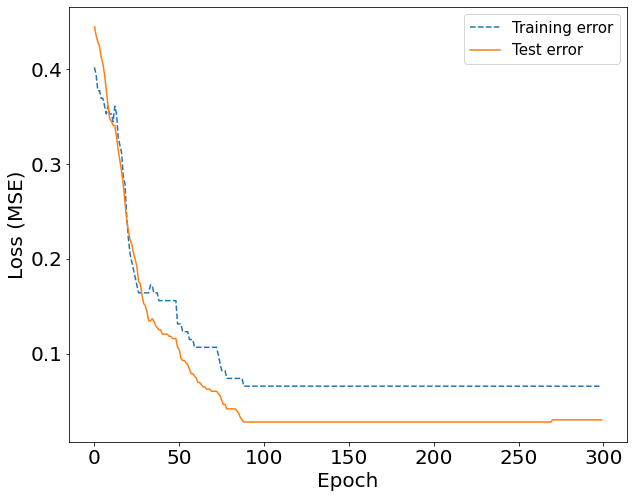

In [52]:
plot_learning_curves(train_loss_M3_mse_noreg, test_loss_M3_mse_noreg, 300, 'Loss (MSE)')

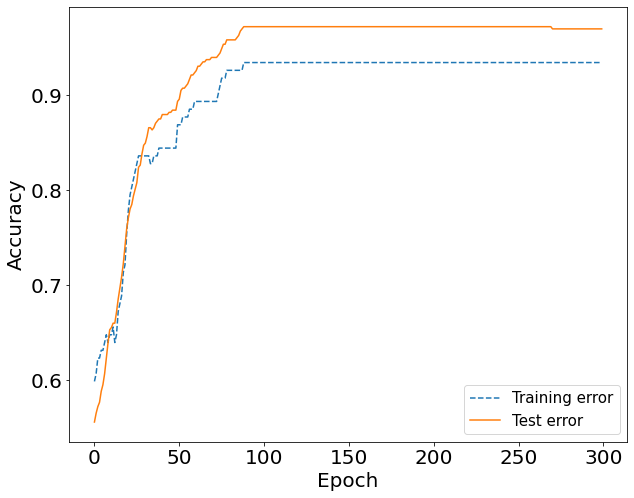

In [53]:
plot_learning_curves(train_scores_M3_noreg, test_scores_M3_noreg, 300, 'Accuracy')

In [54]:
y_predicted_train_M3_noreg = net_enc3_noreg.predict(X_trainFit3)
y_predicted_test_M3_noreg = net_enc3_noreg.predict(X_testFit3)
print(f"Accuracy on MONK3: {net_enc3_noreg.score(X_testFit3, y_testFit3)}")
print(f"MEE on MONK3: {(np.linalg.norm(y_predicted_test_M3_noreg-y_testFit3))}") # MEE distance (a.k.a. norm 2)
print(f"MSE on MONK3 (TRAIN): {(mean_squared_error(y_trainFit3, y_predicted_train_M3_noreg))}")
print(f"MSE on MONK3 (TEST): {(mean_squared_error(y_testFit3, y_predicted_test_M3_noreg))}")

Accuracy on MONK3: 0.9699074074074074
MEE on MONK3: 3.605551242828369
MSE on MONK3 (TRAIN): 0.06557376682758331
MSE on MONK3 (TEST): 0.030092593282461166


In [56]:
#control the accuracy between true and predict values on test data
print(classification_report(y_testFit3, y_predicted_test_M3_noreg))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97       204
         1.0       1.00      0.94      0.97       228

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432



In [57]:
%%time #Wall time: 3.19 s

net_enc3 = NeuralNetBinaryClassifier(
    BinaryClassification,
    module__n_input=X_trainFit3.shape[1],
    module__hidden_units=4,
    max_epochs=1,
    batch_size = 8,
    lr = 0.008,
    optimizer=torch.optim.SGD,
    optimizer__weight_decay=0.0001,
    optimizer__momentum=0.95,
    optimizer__nesterov=True,
    # Shuffle training data on each epoch
    #iterator_train__shuffle=True,
    train_split=None
)

train_scores_M3, test_scores_M3, train_loss_M3, test_loss_M3, train_loss_M3_mse, test_loss_M3_mse = fit_and_score_monk(45, net_enc3, X_trainFit3, y_trainFit3, X_testFit3, y_testFit3)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.7196  0.1007
      2        0.6911  0.0870
      3        0.6595  0.0193
      4        0.6213  0.0193
      5        0.5719  0.0927
      6        0.5117  0.0348
      7        0.4455  0.0916
      8        0.3822  0.0750
      9        0.3301  0.0195
     10        0.2916  0.0233
     11        0.2655  0.0734
     12        0.2467  0.0794
     13        0.2328  0.0891
     14        0.2221  0.0790
     15        0.2136  0.0191
     16        0.2067  0.1016
     17        0.2010  0.0974
     18        0.1962  0.1017
     19        0.1921  0.0965
     20        0.1885  0.1021
     21        0.1854  0.1032
     22        0.1825  0.0921
     23        0.1801  0.0242
     24        0.1777  0.0235
     25        0.1755  0.0256
     26        0.1735  0.0300
     27        0.1716  0.0987
     28        0.1699  0.0184
     29        0.1684  0.0197
     30        0.1669  0.1737
     31        0.1655  0.0898
     32   

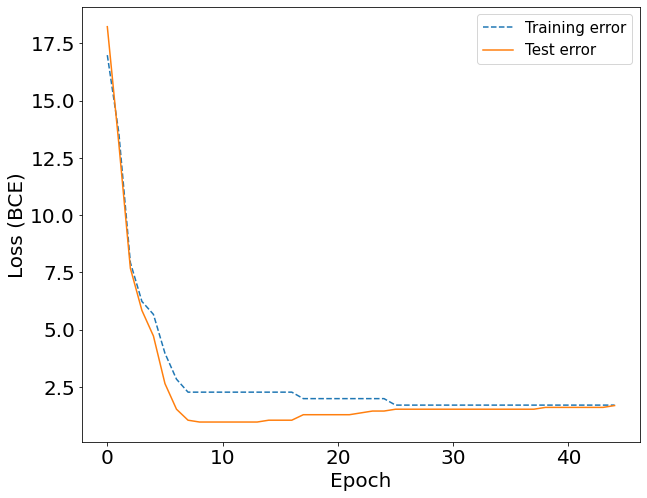

In [58]:
plot_learning_curves(train_loss_M3, test_loss_M3, 45, 'Loss (BCE)')

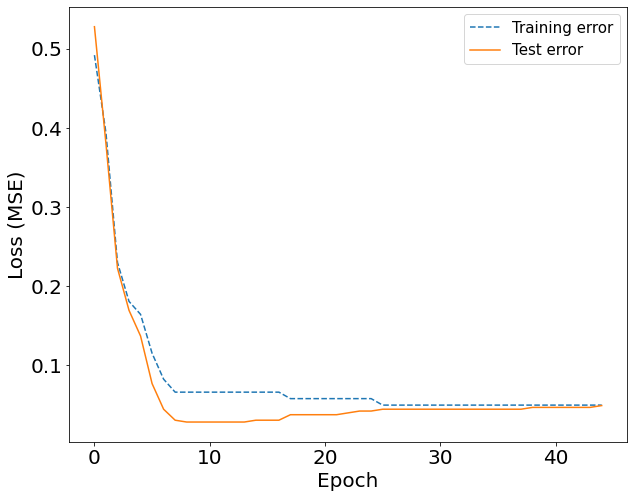

In [59]:
plot_learning_curves(train_loss_M3_mse, test_loss_M3_mse, 45, 'Loss (MSE)')

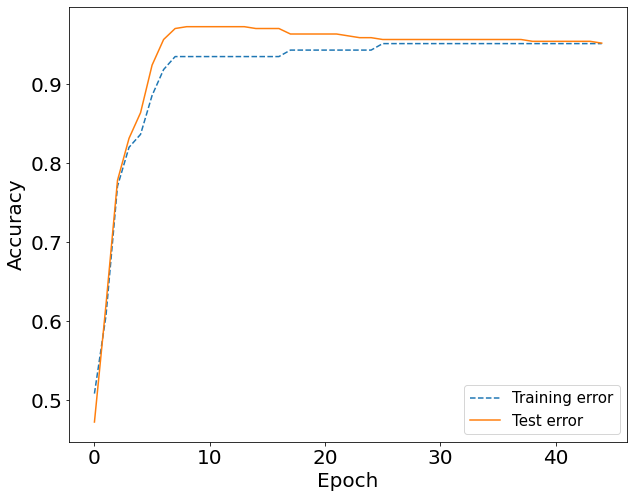

In [60]:
plot_learning_curves(train_scores_M3, test_scores_M3, 45, 'Accuracy')

In [61]:
y_predicted_train_M3 = net_enc3.predict(X_trainFit3)
y_predicted_test_M3 = net_enc3.predict(X_testFit3)
print(f"Accuracy on MONK3: {net_enc3.score(X_testFit3, y_testFit3)}")
print(f"MEE on MONK3: {(np.linalg.norm(y_predicted_test_M3-y_testFit3))}") # MEE distance (a.k.a. norm 2)
print(f"MSE on MONK3 (TRAIN): {(mean_squared_error(y_trainFit3, y_predicted_train_M3))}")
print(f"MSE on MONK3 (TEST): {(mean_squared_error(y_testFit3, y_predicted_test_M3))}")

Accuracy on MONK3: 0.9513888888888888
MEE on MONK3: 4.582575798034668
MSE on MONK3 (TRAIN): 0.04918032884597778
MSE on MONK3 (TEST): 0.0486111119389534


In [62]:
#control the accuracy between true and predict values on test data
print(classification_report(y_testFit3, y_predicted_test_M3))

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       204
         1.0       1.00      0.91      0.95       228

    accuracy                           0.95       432
   macro avg       0.95      0.95      0.95       432
weighted avg       0.96      0.95      0.95       432



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d9d840c9-75b3-4185-bb01-105f5cca8d83' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>